In [1]:
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import pandas as pd
import scipy.signal as signal  # type: ignore
import neurokit2 as nk  # type: ignore
from scipy.interpolate import CubicSpline  # type: ignore

In [2]:
# Add the parent directory to the path to import src as a package
sys.path.insert(0, os.path.abspath('..'))
from src import dataloader
from src import utils
import importlib
importlib.reload(dataloader)

%matplotlib widget 
plot_flag = False

# Load example data for one dyad EEG+ECG

In [3]:
dyad_nr = '030'
dyad_id = f"W{dyad_nr}"
date = "29_07_2025"
time_of_recording = "12_34"
DEV_CG = "A839C92B"  # Caregiver device ID
DEV_CH = "A83E1E24"  # Child device ID

In [4]:
path_H10_child = f'../data/W{dyad_nr}/eeg/W_{dyad_nr}_{date}_{time_of_recording}_{DEV_CH}_IBI.csv'
path10_caregiver = f'../data/W{dyad_nr}/eeg/W_{dyad_nr}_{date}_{time_of_recording}_{DEV_CG}_IBI.csv'

IBI_data_cg = np.genfromtxt(path10_caregiver, delimiter=',')
stage_cg, ibi_t_cg, ibi_cg = IBI_data_cg[:, 0], IBI_data_cg[:, 1], IBI_data_cg[:, 2]
# ibi_t - timestamps of IBI events in recording computer time
# ibi - IBI values in milliseconds
# stage - stage markers of SECORE (not used here)
   
IBI_data_ch = np.genfromtxt(path_H10_child, delimiter=',')
stage_ch, ibi_t_ch, ibi_ch = IBI_data_ch[:, 0], IBI_data_ch[:, 1], IBI_data_ch[:, 2]

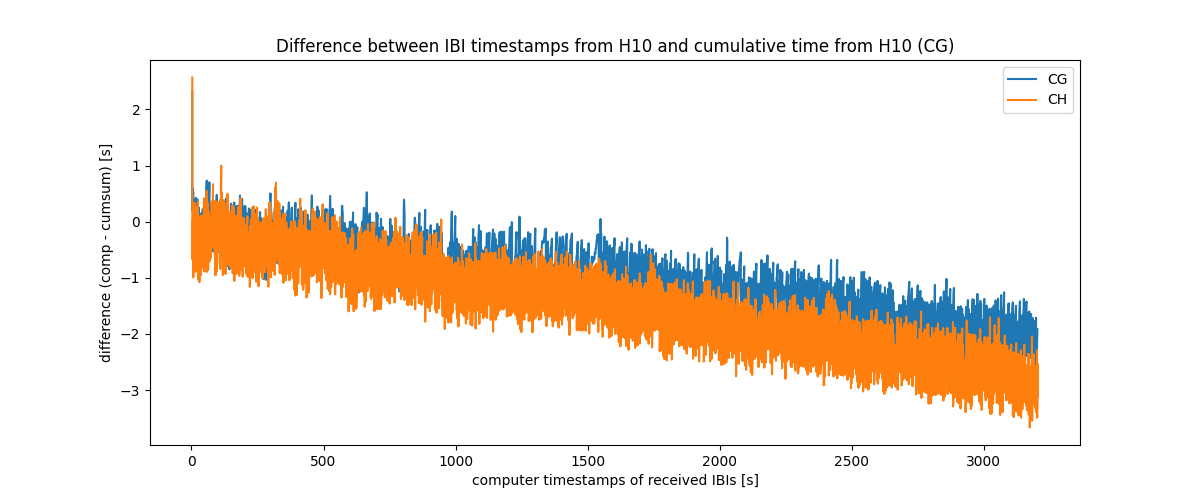

In [5]:

# IBI from H10 are in miliseconds - Convert IBI to seconds 
t_cg_cum_s = np.cumsum(ibi_cg) / 1000 
t_ch_cum_s = np.cumsum(ibi_ch) / 1000 

ifplot = True
if ifplot:
    # check consistency of timestamps from computer and cumulative time from H10
    plt.figure(figsize=(12,5))
    plt.plot(ibi_t_cg, ibi_t_cg - t_cg_cum_s, label='CG') 
    plt.plot(ibi_t_ch,ibi_t_ch - t_ch_cum_s, label='CH') 
    plt.xlabel('computer timestamps of received IBIs [s]')
    plt.ylabel('difference (comp - cumsum) [s]')
    plt.legend()
    plt.title('Difference between IBI timestamps from H10 and cumulative time from H10 (CG)')
    plt.show()


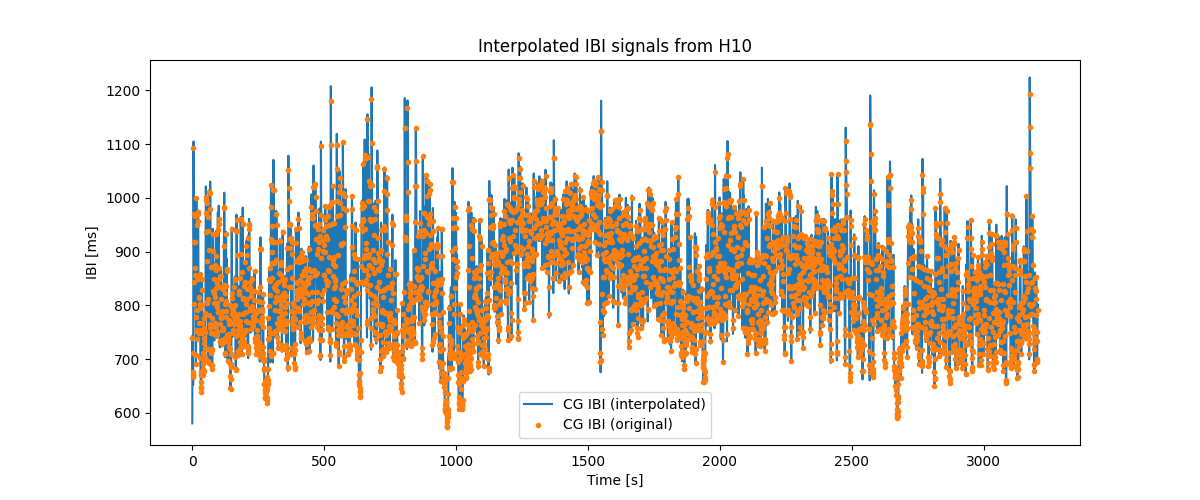

In [6]:
# Fix IBI signals from H10
# - Convert time vectors to samples
Fs_IBI = 8  # Hz, sampling frequency of IBI signals from H10
samp_rate_nk = 1024 # Hz, sampling rate for neurokit2 peak detection (must be higher than Fs_IBI)
t_cg_cum_samp = t_cg_cum_s * samp_rate_nk
t_ch_cum_samp = t_ch_cum_s * samp_rate_nk

_, NN_IBI_cg_pos = nk.signal_fixpeaks(t_cg_cum_samp, sampling_rate=samp_rate_nk, iterative=True, method="Kubios", show=False)
_, NN_IBI_ch_pos = nk.signal_fixpeaks(t_ch_cum_samp, sampling_rate=samp_rate_nk, iterative=True, method="Kubios", show=False)
NN_IBI_cg = np.diff(NN_IBI_cg_pos) / samp_rate_nk * 1000 # to ms
NN_IBI_ch = np.diff(NN_IBI_ch_pos) / samp_rate_nk * 1000

# Interpolate the IBI signals from the H10 to the constant sampling frequency
t_cg = np.cumsum(NN_IBI_cg) / 1000 # Convert cumulative time to seconds
t_ch = np.cumsum(NN_IBI_ch) / 1000
cs_cg = CubicSpline(t_cg, NN_IBI_cg)
cs_ch = CubicSpline(t_ch, NN_IBI_ch)
# t = np.arange(0, np.min((t1[-1], t2[-1])), 1 / Fs_IBI)
# cs_cg = CubicSpline(t_cg_cum_s, ibi_cg)
# cs_ch = CubicSpline(t_ch_cum_s, ibi_ch)

# Interpolate the IBI signals from the H10 to the constant sampling frequency
# and the stages
t_interp = np.arange(0, np.min((t_cg_cum_s[-1], t_ch_cum_s[-1])), 1 / Fs_IBI)
NN_IBI_cg_interp = cs_cg(t_interp)
NN_IBI_ch_interp = cs_ch(t_interp)   
stage_cg_interp  = np.round(np.interp(t_interp, t_cg_cum_s, stage_cg)).astype(int)
stage_ch_interp  = np.round(np.interp(t_interp, t_ch_cum_s, stage_ch)).astype(int)


plt.figure(figsize=(12,5))
plt.plot(t_interp, NN_IBI_cg_interp, label='CG IBI (interpolated)')
plt.plot(t_cg, NN_IBI_cg,'.', label='CG IBI (original)')
plt.xlabel('Time [s]')
plt.ylabel('IBI [ms]')
plt.title('Interpolated IBI signals from H10')
plt.legend()
plt.show()

In [7]:

lowcut=1.0
highcut=40.0
eeg_filter_type = 'iir' # choose 'fir' or 'iir' for EEG filtering
q=8  # decimation factor
multimodal_data = dataloader.create_multimodal_data(data_base_path = "../data", 
                                                    dyad_id = dyad_id, 
                                                    load_eeg=True, 
                                                    load_et=True, 
                                                    lowcut=lowcut, 
                                                    highcut=highcut, 
                                                    eeg_filter_type=eeg_filter_type, 
                                                    interpolate_et_during_blinks_threshold=0.3,
                                                    median_filter_size=64,
                                                    low_pass_et_order=351,
                                                    et_pos_cutoff=128,
                                                    et_pupil_cutoff=4,
                                                    pupil_model_confidence=0.9,
                                                    decimate_factor=q,
                                                    plot_flag=plot_flag)

Detected events: [{'name': 'Brave', 'start': 387.806640625, 'duration': 59.3310546875}, {'name': 'Peppa', 'start': 248.5107421875, 'duration': 59.6328125}, {'name': 'Incredibles', 'start': 318.3603515625, 'duration': 59.212890625}, {'name': 'Talk_1', 'start': 594.4892578125, 'duration': 181.0556640625}, {'name': 'Talk_2', 'start': 836.7275390625, 'duration': 181.056640625}]
Applying iir filters to EEG data.
Reseting the EEG time to the start of Peppa
ET time range: 241.59s to 461.89s
Events from ET annotations:
[None 'Peppa' 'Incredibles' 'Brave']
Reseting the ET time to the start of Peppa
Processing member: ch, blink column: ET_ch_blinks
Processing member: cg, blink column: ET_cg_blinks
Column ET_ch_blinks contains NaN values, applying forward fill before decimation.
Column ET_cg_blinks contains NaN values, applying forward fill before decimation.
Event Peppa start times are consistent within 0.0 seconds.
Event Incredibles differ in start times by: abs(0.0078125) seconds.
Event Brave 

In [8]:
print(f'Current multimodal_data.fs: {multimodal_data.fs}')

Current multimodal_data.fs: 128.0


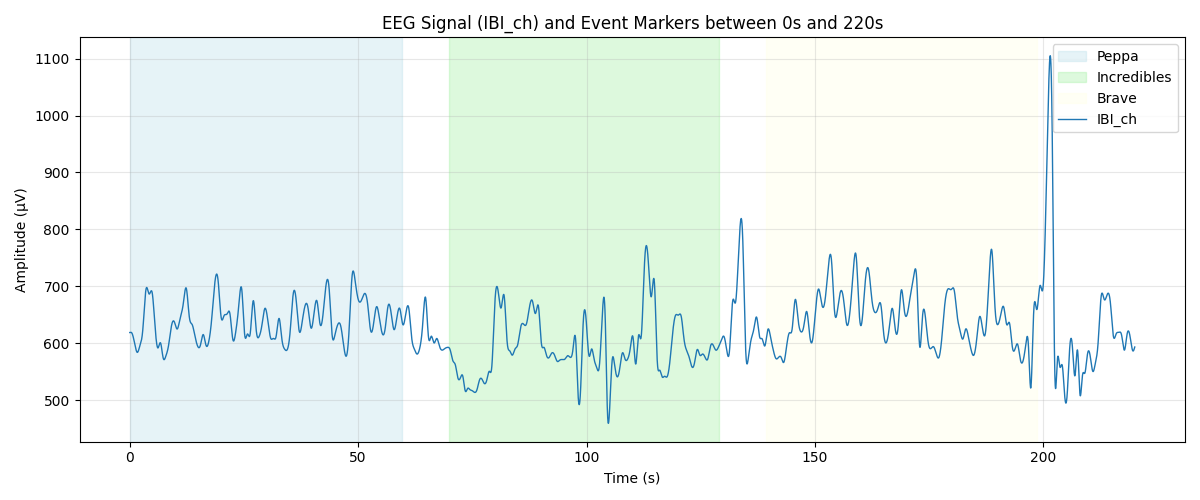

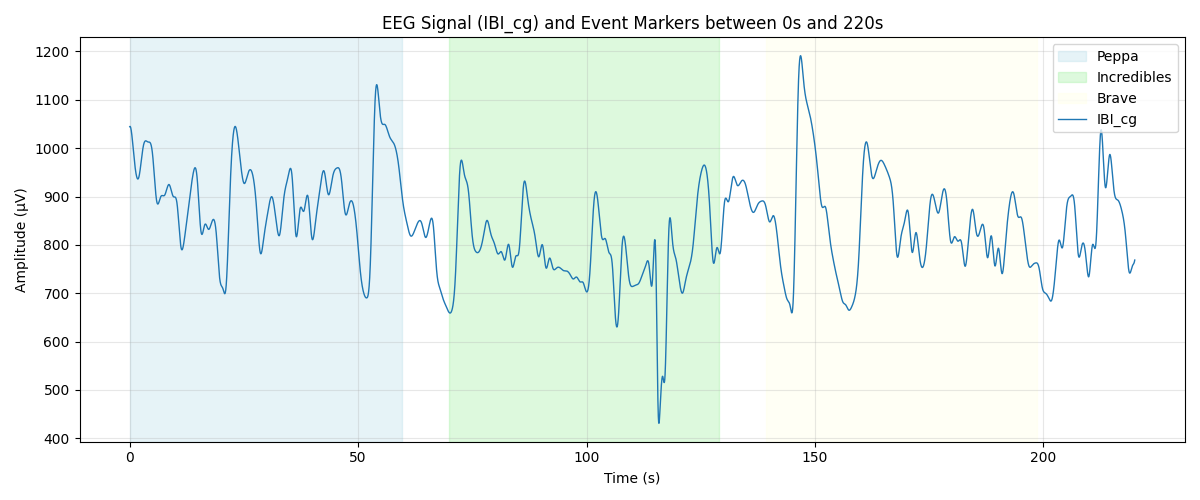

In [9]:
# Get selected child EEG channels for specific event and time window
seleted_time = [0, 220]


time, channels_IBI_ch, data_IBI_ch = multimodal_data.get_signals(
                mode='IBI', 
                member='ch', 
                selected_channels=[''],
                selected_times=seleted_time
            )
time, channels_IBI_cg, data_IBI_cg = multimodal_data.get_signals(
                mode='IBI', 
                member='cg', 
                selected_channels=[''],
                selected_times=seleted_time
            )
time, marker_channel, event_to_marker = multimodal_data.get_events_as_marker_channel(selected_times=seleted_time)

utils.plot_signal_with_events(time, data_IBI_ch,channels_IBI_ch, marker_channel, event_to_marker, seleted_time)
utils.plot_signal_with_events(time, data_IBI_cg,channels_IBI_cg, marker_channel, event_to_marker, seleted_time)

## Let's downsample the multimodal_data to 8 Hz
For the synchronization of IBI derived from ECG recorded by Porti and IBI dervied from H10 sensors we do ot need veryhigh saamplig frequency.
8 Hz sholud be enough.

But first Let's make sure that the downsampling dosen't disturb the IBIs

In [10]:
mmd = multimodal_data._decimate_signals(q = 16)
print(f'Current multimodal_data.fs after decimation: {mmd.fs}')

Column ET_ch_blinks contains NaN values, applying forward fill before decimation.
Column ET_cg_blinks contains NaN values, applying forward fill before decimation.
Current multimodal_data.fs after decimation: 8.0


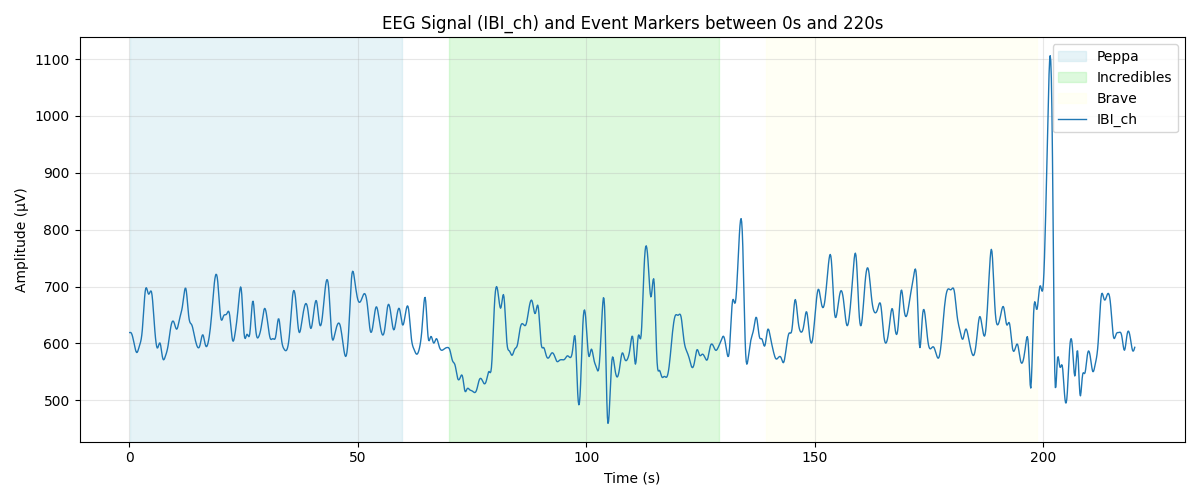

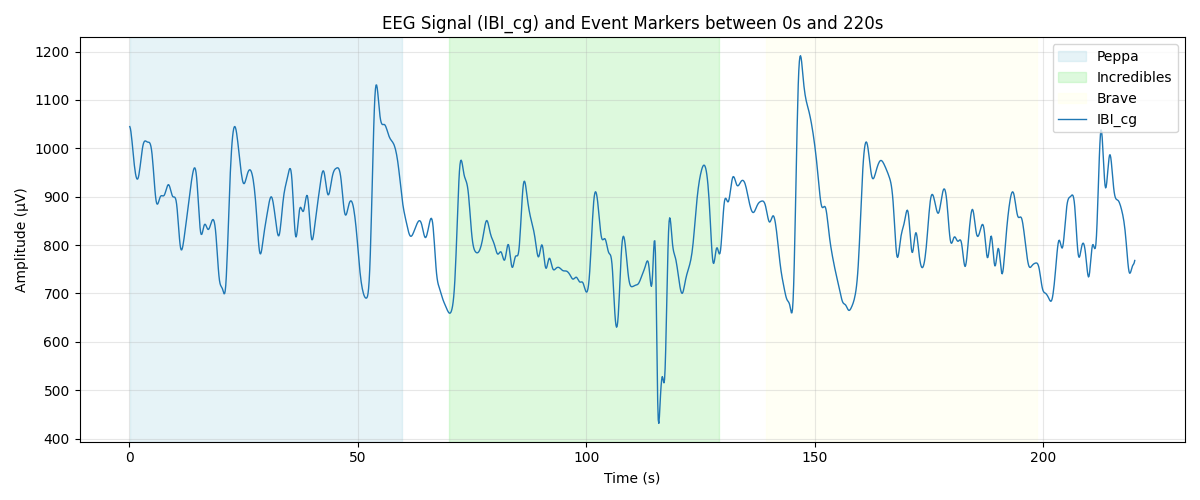

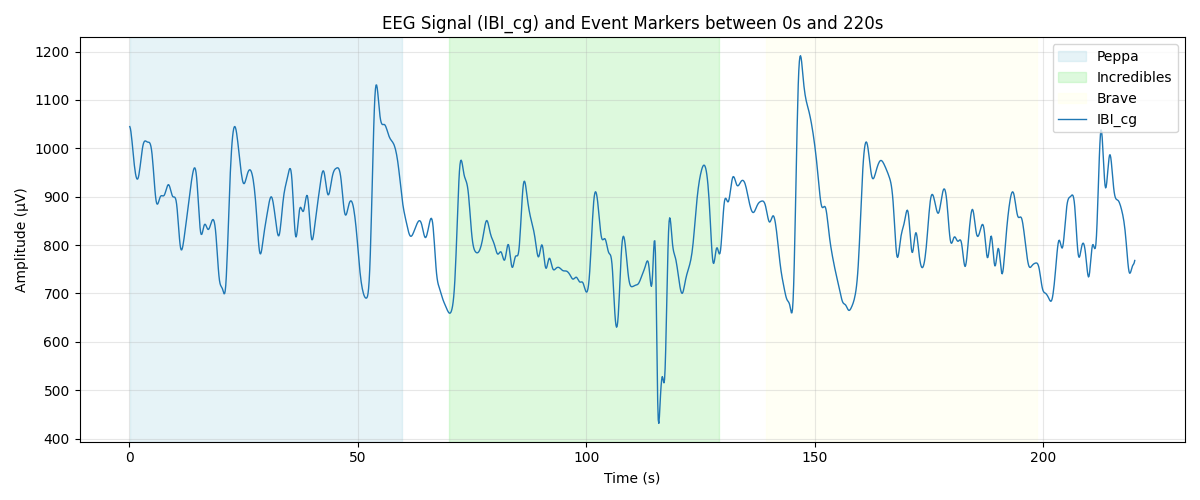

In [11]:
# Get selected child EEG channels for specific event and time window
seleted_time = [0, 220]


time_8, channels_IBI_ch_8, data_IBI_ch_8 = mmd.get_signals(
                mode='IBI', 
                member='ch', 
                selected_channels=[''],
                selected_times=seleted_time
            )
time_8, channels_IBI_cg_8, data_IBI_cg_8 = mmd.get_signals(
                mode='IBI', 
                member='cg', 
                selected_channels=[''],
                selected_times=seleted_time
            )
time_8, marker_channel, event_to_marker = mmd.get_events_as_marker_channel(selected_times=seleted_time)

utils.plot_signal_with_events(time_8, data_IBI_ch_8,channels_IBI_ch_8, marker_channel, event_to_marker, seleted_time)
utils.plot_signal_with_events(time_8, data_IBI_cg_8,channels_IBI_cg_8, marker_channel, event_to_marker, seleted_time)
plt.show()

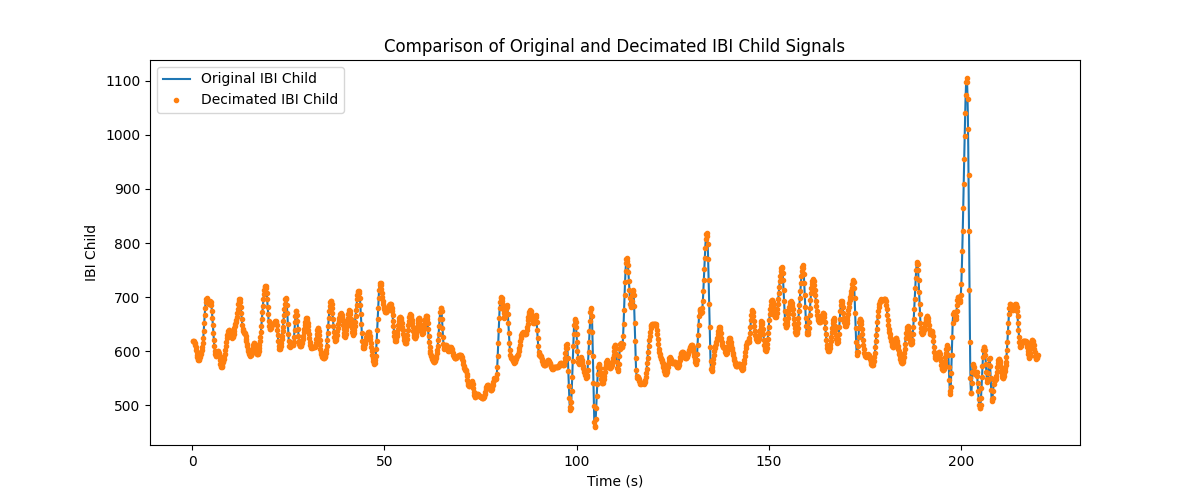

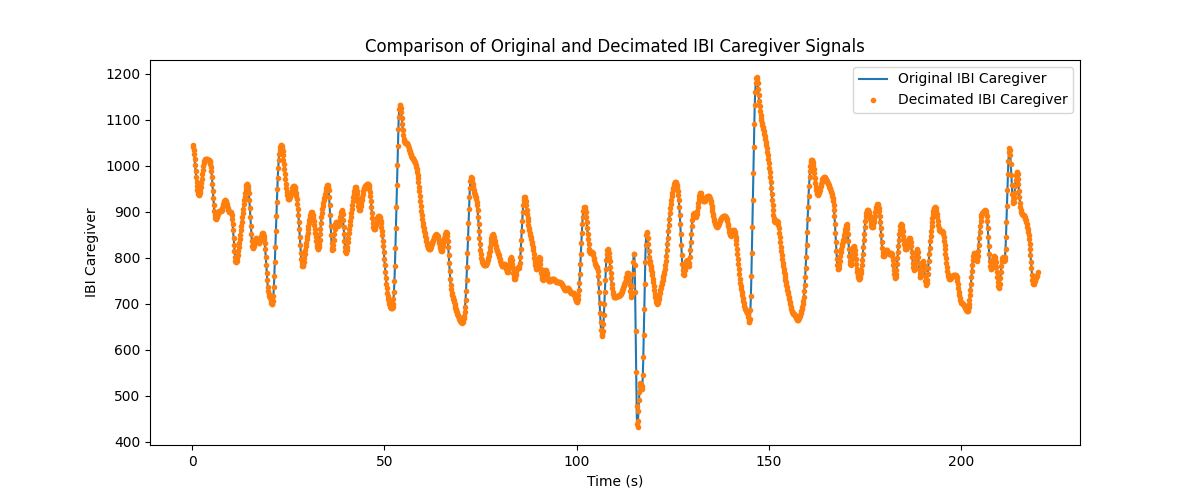

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(time, data_IBI_ch, label='Original IBI Child')
plt.plot(time_8, data_IBI_ch_8,'.', label='Decimated IBI Child')
plt.xlabel('Time (s)')
plt.ylabel('IBI Child')
plt.title('Comparison of Original and Decimated IBI Child Signals')
plt.legend()
plt.show()
plt.figure(figsize=(12, 5))
plt.plot(time, data_IBI_cg, label='Original IBI Caregiver')
plt.plot(time_8, data_IBI_cg_8,'.', label='Decimated IBI Caregiver')
plt.xlabel('Time (s)')
plt.ylabel('IBI Caregiver')
plt.title('Comparison of Original and Decimated IBI Caregiver Signals')
plt.legend()    
plt.show()

## Align the IBIs from Porit and H10

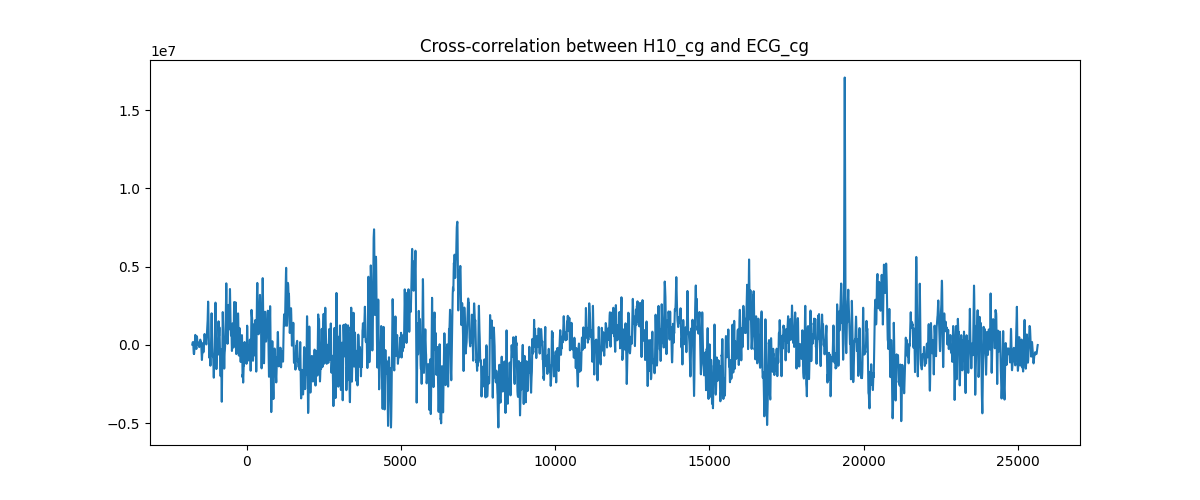

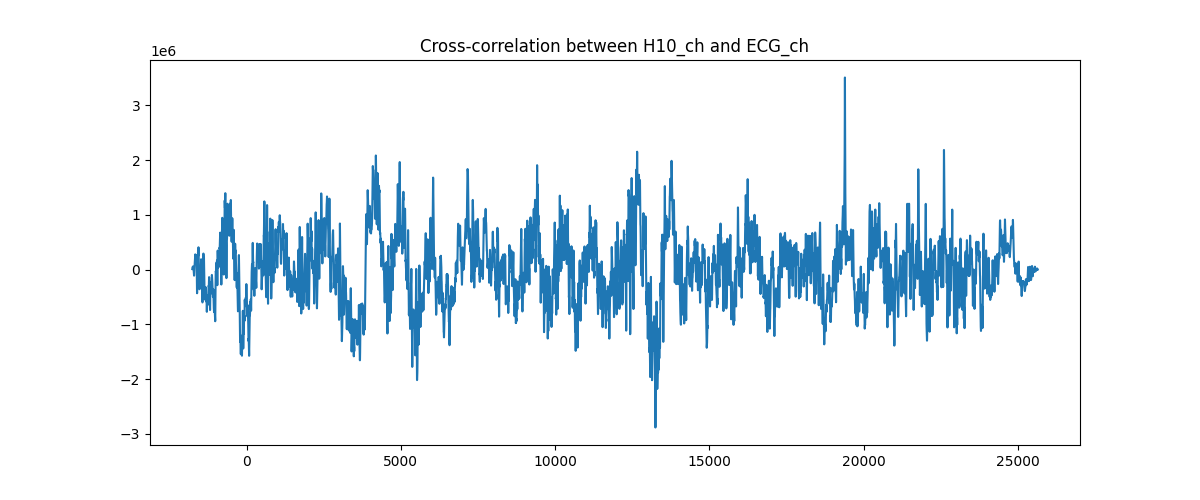

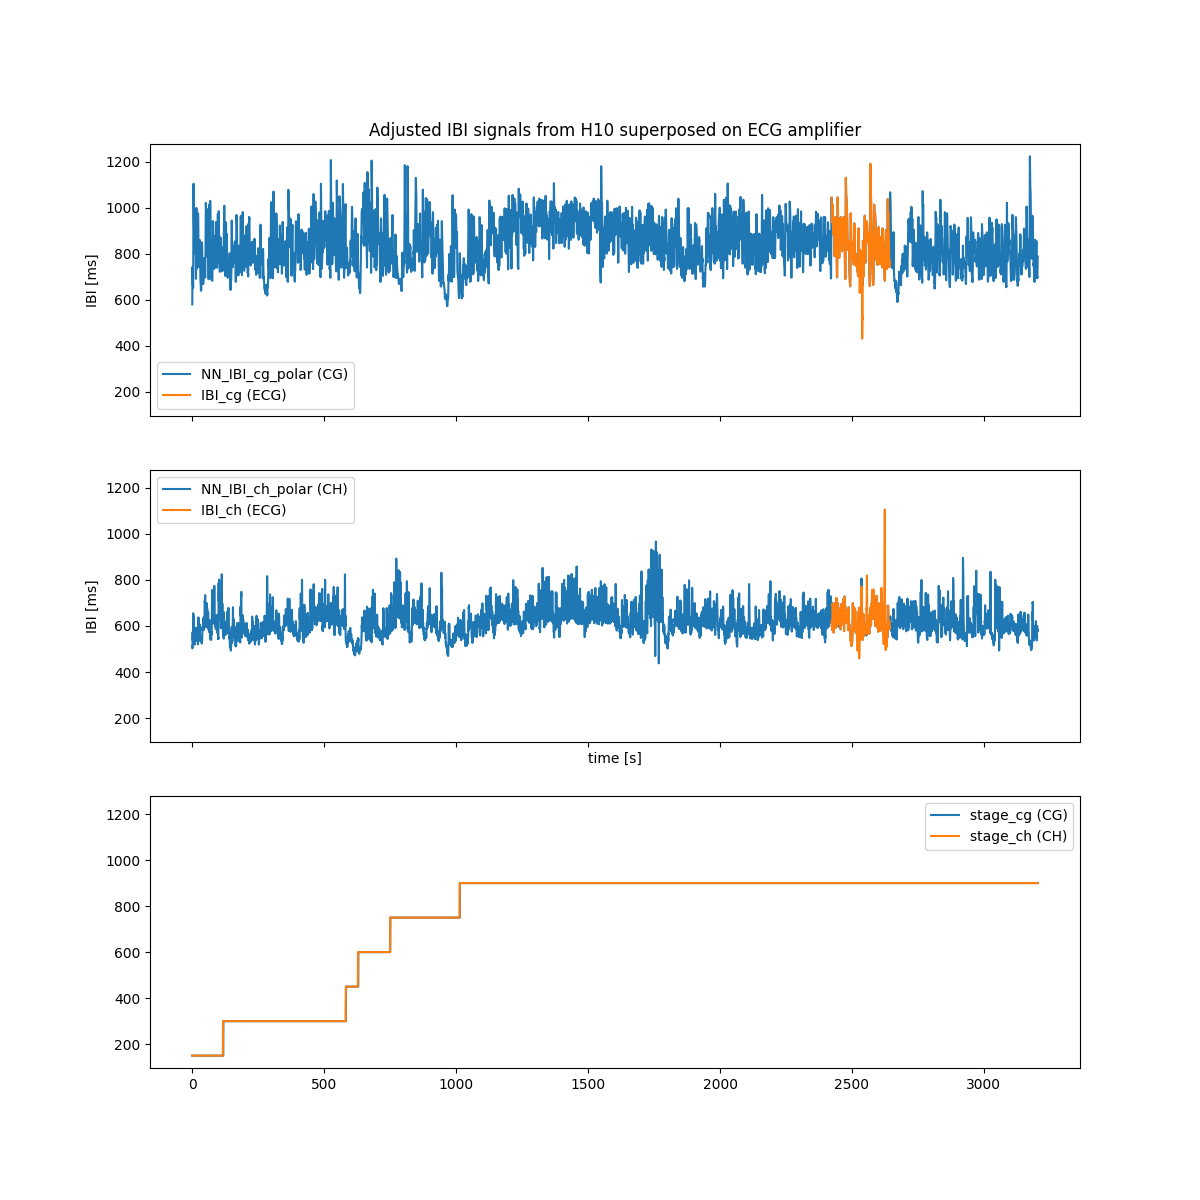

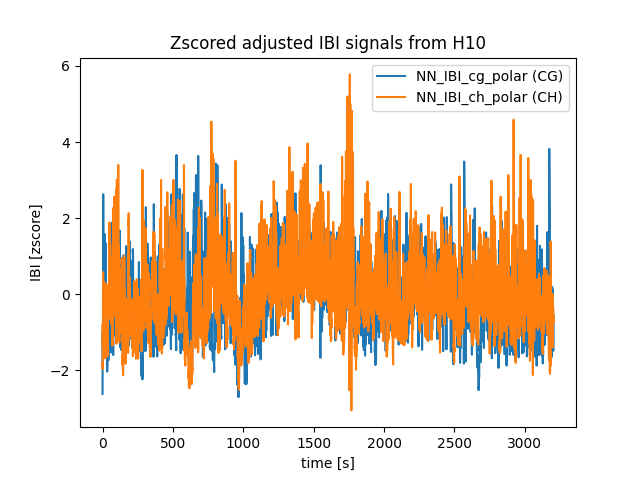

In [13]:
def compute_signal_lag(signal1, signal2, plot=False, label1='', label2=''):
    signal1 = signal1.flatten() 
    signal2 = signal2.flatten() 
    cross_corr = signal.correlate(signal1- np.mean(signal1) , signal2- np.mean(signal2) , mode='full')
    lags = signal.correlation_lags(signal1.size, signal2.size, mode="full")
    lag = lags[np.argmax(cross_corr)]

    if plot:
        plt.figure(figsize=(12,5))
        plt.plot(lags, cross_corr)
        plt.title(f'Cross-correlation between {label1} and {label2}')
        plt.show()

    return lag


# Match the IBI interpolated signals from amplifier and H10
lag_cg = compute_signal_lag(NN_IBI_cg_interp, data_IBI_cg_8, plot=ifplot, label1='H10_cg', label2='ECG_cg')
lag_ch = compute_signal_lag(NN_IBI_ch_interp, data_IBI_ch_8, plot=ifplot, label1='H10_ch', label2='ECG_ch')
# Adjust the lags of the IBI signals from the H10
lag_diff = lag_ch - lag_cg
if lag_diff > 0:
    NN_IBI_ch_interp = NN_IBI_ch_interp[lag_diff:]
    NN_IBI_cg_interp = NN_IBI_cg_interp[:-lag_diff]
    stage_ch_interp = stage_ch_interp[lag_diff:]
    stage_cg_interp = stage_cg_interp[:-lag_diff]
else:    
    NN_IBI_cg_interp = NN_IBI_cg_interp[-lag_diff:]
    NN_IBI_ch_interp = NN_IBI_ch_interp[:lag_diff]
    stage_cg_interp = stage_cg_interp[-lag_diff:]
    stage_ch_interp = stage_ch_interp[:lag_diff]    

t_H10 = np.arange(0, len(NN_IBI_cg_interp) / Fs_IBI, 1 / Fs_IBI)

NN_IBI_cg_interp_z = (NN_IBI_cg_interp - np.mean(NN_IBI_cg_interp)) / np.std(NN_IBI_cg_interp)
NN_IBI_ch_interp_z = (NN_IBI_ch_interp - np.mean(NN_IBI_ch_interp)) / np.std(NN_IBI_ch_interp)

# Save the adjusted IBI signals
df = pd.DataFrame({'t': t_H10, 'NN_IBI_cg_interp_CG': NN_IBI_cg_interp_z, 'NN_IBI_ch_interp_CH': NN_IBI_ch_interp_z})
    
ifplot=True
if ifplot:
    # Plot the adjusted IBI signals
    fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(12,12))
    ax[0].plot(t_H10, NN_IBI_cg_interp, label='NN_IBI_cg_polar (CG)')
    ax[1].plot(t_H10, NN_IBI_ch_interp, label='NN_IBI_ch_polar (CH)')
    start_t_ECG = np.min((lag_ch,lag_cg))
    stop_t_ECG  = np.min((lag_ch,lag_cg))+len(data_IBI_ch_8)
    t_ECG = np.arange(start_t_ECG, stop_t_ECG, 1)/Fs_IBI
    ax[0].plot(t_ECG, data_IBI_cg_8, label='IBI_cg (ECG)')
    ax[1].plot(t_ECG, data_IBI_ch_8, label='IBI_ch (ECG)')
    ax[2].plot(t_H10, stage_cg_interp*150, label='stage_cg (CG)')
    ax[2].plot(t_H10, stage_ch_interp*150, label='stage_ch (CH)')
    ax[1].set_xlabel('time [s]')
    ax[0].set_ylabel('IBI [ms]')
    ax[1].set_ylabel('IBI [ms]')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].set_title('Adjusted IBI signals from H10 superposed on ECG amplifier')
    plt.show()
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True)
    ax.plot(t_H10, NN_IBI_cg_interp_z, label='NN_IBI_cg_polar (CG)')
    ax.plot(t_H10, NN_IBI_ch_interp_z, label='NN_IBI_ch_polar (CH)')
    ax.set_xlabel('time [s]')
    ax.set_ylabel('IBI [zscore]')        
    ax.legend()
    ax.set_title('Zscored adjusted IBI signals from H10')
    plt.show()
   



## SECORE phases:
- T1 Synchronization sound, after all 3 cameras are on, from start to finish
- T2 Experimentator leaves the room 2000 ms later
- T3 Bell sound, the full ringing done by mom
- T4 Researcher’s Mask, when the researcher enters the room and is visible on camera

- puzzle.	            m1 [T2 + 1.0, T2 + 2.5] 
- cleaning.           m2 [T3 - 1.5, T3]
- wrong present.      m3 [T3,       T3 + 1.5]
- surprise.           m4 [T4,       T4 + 1.5]


In [14]:
# Read lines 5-8 from W_030_1_25fps.txt
file_path = f'../data/W{dyad_nr}/eeg/W_{dyad_nr}_1_25fps.txt'

# Read specific lines (Python is 0-indexed, so lines 5-8 are indices 4-7)
with open(file_path, 'r') as f:
    lines = f.readlines()
    selected_lines = lines[4:8]

# Parse the lines into a dataframe
# The format appears to be: Label  Start_Time_HH:MM:SS  Start_Time_Sec  End_Time_HH:MM:SS  End_Time_Sec  Duration_HH:MM:SS  Duration_Sec
data = []
for line in selected_lines:
    parts = line.strip().split('\t')
    if len(parts) >= 7:
        data.append(parts)

df_timings = pd.DataFrame(data, columns=['Label', 'Start_HH_MM_SS', 'Start_Sec', 'End_HH_MM_SS', 'End_Sec', 'Duration_HH_MM_SS', 'Duration_Sec'])

# Convert numeric columns to float
df_timings['Start_Sec'] = df_timings['Start_Sec'].astype(float)
df_timings['End_Sec'] = df_timings['End_Sec'].astype(float)
df_timings['Duration_Sec'] = df_timings['Duration_Sec'].astype(float)

print(df_timings)

  Label Start_HH_MM_SS  Start_Sec  End_HH_MM_SS  End_Sec Duration_HH_MM_SS  \
0    T1   00:00:10.350     10.350  00:00:12.350   12.350      00:00:02.000   
1    T2   00:01:59.470    119.470  00:02:01.470  121.470      00:00:02.000   
2    T3   00:10:34.857    634.857  00:10:36.857  636.857      00:00:02.000   
3    T4   00:12:46.940    766.940  00:12:48.940  768.940      00:00:02.000   

   Duration_Sec  
0           2.0  
1           2.0  
2           2.0  
3           2.0  


In [15]:
# Subtract the T1 Start_Sec value from all Start_Sec values
t1_start = df_timings[df_timings['Label'] == 'T1']['Start_Sec'].values[0]
df_timings['Start_Sec'] = df_timings['Start_Sec'] - t1_start
df_timings['End_Sec'] = df_timings['End_Sec'] - t1_start

print(df_timings)

  Label Start_HH_MM_SS  Start_Sec  End_HH_MM_SS  End_Sec Duration_HH_MM_SS  \
0    T1   00:00:10.350      0.000  00:00:12.350    2.000      00:00:02.000   
1    T2   00:01:59.470    109.120  00:02:01.470  111.120      00:00:02.000   
2    T3   00:10:34.857    624.507  00:10:36.857  626.507      00:00:02.000   
3    T4   00:12:46.940    756.590  00:12:48.940  758.590      00:00:02.000   

   Duration_Sec  
0           2.0  
1           2.0  
2           2.0  
3           2.0  


In [24]:
# złapać kiedy następuje przejscie z stage 1 do stage 2 na sygnale stage_cg_interp i stage_ch_interp, wcześniejsze z tych przejść ustawić jako czas 0
x = np.min(np.where(stage_cg_interp==2))
y = np.min(np.where(stage_ch_interp==2))
v = np.min((x,y))
print(f'x {x}, y {y} chosen v {v}')
t_H10 = t_H10 - t_H10[v]


x 941, y 929 chosen v 929


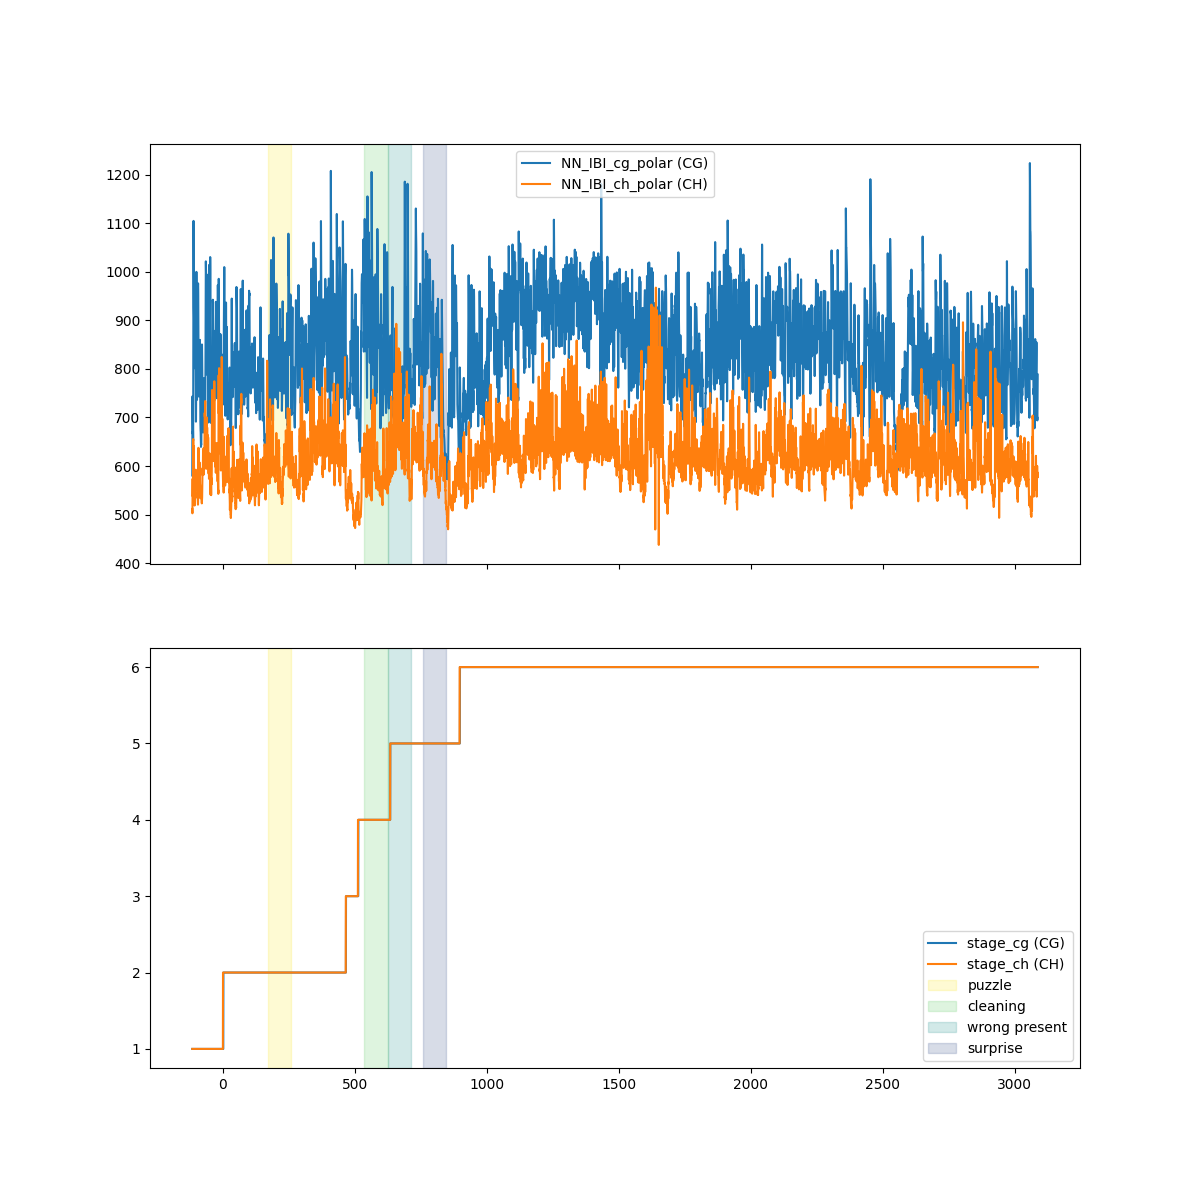

In [32]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(12,12)) 
ax[0].plot(t_H10, NN_IBI_cg_interp, label='NN_IBI_cg_polar (CG)')
ax[0].plot(t_H10, NN_IBI_ch_interp, label='NN_IBI_ch_polar (CH)')
ax[1].plot(t_H10, stage_cg_interp, label='stage_cg (CG)')
ax[1].plot(t_H10, stage_ch_interp, label='stage_ch (CH)')

# define moments of stages based on df_timings
# puzzle.              m1 [T2 + 1.0, T2 + 2.5] 
# cleaning.            m2 [T3 - 1.5, T3]
# wrong present.       m3 [T3,       T3 + 1.5]
# surprise.            m4 [T4,       T4 + 1.5]

moments = pd.DataFrame([
    {
        'moment': 'puzzle',
        'start': df_timings[df_timings['Label'] == 'T2']['Start_Sec'].values[0] + 1.0*60,
        'end': df_timings[df_timings['Label'] == 'T2']['Start_Sec'].values[0] + 2.5*60,
    },
    {
        'moment': 'cleaning',
        'start': df_timings[df_timings['Label'] == 'T3']['Start_Sec'].values[0] - 1.5*60,
        'end': df_timings[df_timings['Label'] == 'T3']['Start_Sec'].values[0],
    },
    {
        'moment': 'wrong present',
        'start': df_timings[df_timings['Label'] == 'T3']['Start_Sec'].values[0],
        'end': df_timings[df_timings['Label'] == 'T3']['Start_Sec'].values[0] + 1.5*60,
    },
    {
        'moment': 'surprise',
        'start': df_timings[df_timings['Label'] == 'T4']['Start_Sec'].values[0],
        'end': df_timings[df_timings['Label'] == 'T4']['Start_Sec'].values[0] + 1.5*60,
    },
])

# Mark stages with background colors based on df_timings
stage_colors = {
    'puzzle': '#fde725',
    'cleaning': '#5ec962',
    'wrong present': '#21918c',
    'surprise': '#3b528b'
}

for _, row in moments.iterrows():
    label = row['moment']
    start = row['start']
    end = row['end']
    color = stage_colors.get(label, '#bbbbbb')
    ax[0].axvspan(start, end, color=color, alpha=0.2)
    ax[1].axvspan(start, end, color=color, alpha=0.2, label=label)

# Deduplicate legend entries for stages
handles, labels = ax[1].get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax[1].legend(unique.values(), unique.keys(), loc='upper right')

ax[0].legend()
ax[1].legend()
plt.show()